In [388]:
import pandas as pd 
import numpy as np
from pandas_datareader import data, wb
import pandas_datareader as pdr
import FinanceDataReader as fdr
import matplotlib.pyplot as plt
import datetime
import math
fdr.__version__

'0.9.31'

* ticker data를 local csv 에 저장해서 cache 만들기
* library화

LTHM
* 필터
  직전 20일 기준 일평균 거래 금액이 5000만 달러 초과
  최소 주가 5달러
* 설정
  S&P500 종가가 100일 이동평균선 위에 있어야 함
  종목의 25일 이동평균 종가가 50일 이동평균 종가보다 높아야 함
* 순위
  200일 동안 가장 높은 수익률 순으로 순위 부여
* 포지션
  최대 10개 포지션, 포지션별 총자산 대비 2% 위험, 총자산 대비 최대 10% 자산 배분
* 손절매
  매수당일 체결 가격을 기준으로 직전 20일 ATR(Average Trade Range)의 5배 위의 지점
* 수익보호
  25% 추격 역지정가 (주가가 상승하면 추격 역지정가 상승)

In [645]:
MOMENTUM_DAYS = 180 # 6개월

now = datetime.datetime.now()
start_time = datetime.datetime(2020, 1, 1, 9, 0, 0)
end_time = datetime.datetime(2021, 9, 5, 9, 0, 0)
#EST = datetime.timezone(datetime.timedelta(hours=-5))
#start_time = datetime.datetime(2020, 1, 1, 9, 0, 0, tzinfo=EST)
#start_time = datetime.datetime.strptime("20200101", "%Y%m%d")
#end_time = datetime.datetime.strptime("20210101", "%Y%m%d")
#start_time = now - datetime.timedelta(weeks=52) # 1년 전으로 start 설정
#end_time = now - datetime.timedelta(weeks=4) # 1달 전으로 end 설정
prev_start_time = start_time - datetime.timedelta(days=MOMENTUM_DAYS)
prev_end_time = start_time - datetime.timedelta(days=1)

std_list = { 
    "KS11": { "name": "KOSPI" },
    "KS200": { "name": "KOSPI200" }
}
ticker_list = {
    "005930.KS": { "name": "Samsung"},
    "066570.KS": { "name": "LG전자"}
}
system_list = {
}


In [643]:
# DataFrame
def get_rate_of_return(x):
    return round((x.iloc[-1]-x.iloc[0]),2)

def add_relative_value(ticker_data, src_name):
    # 100기준 종가 컬럼 추가
    ticker_data['relative_value'] = ticker_data[src_name] / ticker_data[src_name].iloc[0]*100
    
def get_ticker_data(code, start_time, end_time, use_fdr=False):
    global MOMENTUM_DAYS
    prev_start_time = start_time - datetime.timedelta(days=MOMENTUM_DAYS)
    prev_end_time = start_time - datetime.timedelta(days=1)
    
    if (use_fdr):
        prev_data = fdr.DataReader(code, prev_start_time, prev_end_time)
        ticker_data = fdr.DataReader(code, start_time, end_time)
        total_data = pd.concat([prev_data, ticker_data])
    else:
        prev_data = pdr.data.get_data_yahoo(code, prev_start_time, prev_end_time)
        ticker_data = pdr.data.get_data_yahoo(code, start_time, end_time)
        total_data = pd.concat([prev_data, ticker_data])

    # 180일전 종가 컬럼, 180일전 대비 수익율 컬럼 추가
    prev_close180 = total_data[:len(ticker_data)]
    ticker_data['prev_close180'] = prev_close180['Close'].values
    prev_rate180 = (ticker_data['Close'] - ticker_data['prev_close180'])/ticker_data['prev_close180']*100
    ticker_data['prev_rate180'] = prev_rate180.values
    
    # 100기준 종가 컬럼 추가
    add_relative_value(ticker_data, 'Close')
    #ticker_data['relative_close'] = ticker_data['Close'] / ticker_data['Close'].iloc[0]*100
    
    # 이동평균 컬럼 추가
    ma5 = total_data['Close'].rolling(window=5).mean()
    ma25 = total_data['Close'].rolling(window=25).mean()
    ma50 = total_data['Close'].rolling(window=50).mean()
    ma100 = total_data['Close'].rolling(window=100).mean()
    ticker_data['ma5'] = ma5[len(prev_data):]
    ticker_data['ma25'] = ma25[len(prev_data):]
    ticker_data['ma50'] = ma50[len(prev_data):]
    ticker_data['ma100'] = ma100[len(prev_data):]
    return ticker_data

# 차트
def show_chart():
    fig = plt.figure(figsize=(10,5))
    fig.tight_layout()
    subplot = fig.add_subplot(1,1,1)

    for k, v in std_list.items():
        name = v['name']
        ticker_data = v['data']
        subplot.plot(ticker_data['relative_value'], label=name)
        subplot.legend()

    for k, v in ticker_list.items():
        name = v['name']
        ticker_data = v['data']
        subplot.plot(ticker_data['relative_value'], label=name)
        subplot.legend()

    name = 'LTHM'
    ticker_data = system.data
    subplot.plot(ticker_data['relative_value'], label=name)
    subplot.legend()
    #plt.show()
    return subplot

In [647]:
for k, v in std_list.items():
    code = k
    std_list[code]['data'] = get_ticker_data(code, start_time, end_time, use_fdr=True)

In [649]:
for k, v in ticker_list.items():
    code = k
    ticker_list[code]['data'] = get_ticker_data(code, start_time, end_time)

In [612]:
#ticker_list_one = ticker_list.copy()
#del ticker_list_one['005930.KS']
#ticker_list_two = ticker_list.copy()

# 데이터 탐색

## DataFrame append

In [489]:
dates = pd.date_range("20130101", periods=6)
print(type(dates[0]))
df = pd.DataFrame(columns=['A', 'B'])
for i in range(5):
    df = df.append(pd.Series({'A':i, 'B':i}, index=df.columns, name=dates[i]))
df.head()

<class 'pandas._libs.tslibs.timestamps.Timestamp'>


,A,B
2013-01-01,0,0
2013-01-02,1,1
2013-01-03,2,2
2013-01-04,3,3
2013-01-05,4,4


## 상장 주식 목록

In [248]:
# 한국거래소 상장종목 전체
df_krx = fdr.StockListing('KRX') # KRX, KOSPI, KOSDAQ
print(len(df_krx))
df_krx.head()

7118


,Symbol,Market,Name,Sector,Industry,ListingDate,SettleMonth,Representative,HomePage,Region
0,060310,KOSDAQ,3S,전자부품 제조업,반도체 웨이퍼 캐리어,2002-04-23,03월,"박종익, 김세완 (각자 대표이사)",http://www.3sref.com,서울특별시
1,095570,KOSPI,AJ네트웍스,산업용 기계 및 장비 임대업,"렌탈(파렛트, OA장비, 건설장비)",2015-08-21,12월,박대현,http://www.ajnet.co.kr,서울특별시
2,006840,KOSPI,AK홀딩스,기타 금융업,지주사업,1999-08-11,12월,"채형석, 이석주(각자 대표이사)",http://www.aekyunggroup.co.kr,서울특별시
3,054620,KOSDAQ,APS홀딩스,기타 금융업,인터넷 트래픽 솔루션,2001-12-04,12월,정기로,http://www.apsholdings.co.kr,경기도
4,265520,KOSDAQ,AP시스템,특수 목적용 기계 제조업,디스플레이 제조 장비,2017-04-07,12월,김영주,http://www.apsystems.co.kr,경기도


In [ ]:
# KRX stock delisting symbol list 상장폐지 종목 전체 리스트
krx_delisting = fdr.StockListing('KRX-DELISTING')

# KRX stock delisting symbol list and names 관리종목 리스트
krx_adm = fdr.StockListing('KRX-ADMINISTRATIVE') # 관리종목

## 주가 가져오기 - pdr & fdr

In [635]:
code = '^KS11'
ticker_data = pdr.data.get_data_yahoo(code, start_time, end_time)
ticker_data.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2020-01-02,2202.320068,2171.840088,2201.209961,2175.169922,494700,2175.169922
2020-01-03,2203.379883,2165.389893,2192.580078,2176.459961,631600,2176.459961
2020-01-06,2164.419922,2149.949951,2154.969971,2155.070068,592700,2155.070068
2020-01-07,2181.620117,2164.270020,2166.600098,2175.540039,568200,2175.540039
2020-01-08,2162.320068,2137.719971,2156.270020,2151.310059,913800,2151.310059


In [439]:
code = '005930.KS'
ticker_data = pdr.data.get_data_yahoo(code, start_time, end_time)
ticker_data.head()

,High,Low,Open,Close,Volume,Adj Close,prev_close180,prev_rate180,relative_value,ma5,ma25,ma50,ma100
Date,,,,,,,,,,,,,
2020-01-02,56000.0,55000.0,55500.0,55200.0,12993228.0,52305.605469,45650.0,20.920044,100.000000,55580.0,53238.0,52535.0,49458.5
2020-01-03,56600.0,54900.0,56000.0,55500.0,15422255.0,52589.875000,44400.0,25.000000,100.543478,55680.0,53386.0,52639.0,49574.0
2020-01-06,55600.0,54600.0,54900.0,55500.0,10278951.0,52589.875000,45100.0,23.059867,100.543478,55700.0,53518.0,52725.0,49694.0
2020-01-07,56400.0,55600.0,55700.0,55800.0,10009778.0,52874.144531,45550.0,22.502744,101.086957,55560.0,53698.0,52817.0,49820.0
2020-01-08,57400.0,55900.0,56200.0,56800.0,23501171.0,53821.703125,46200.0,22.943723,102.898551,55760.0,53958.0,52939.0,49961.5


In [634]:
code = 'KS11'
ticker_data = fdr.DataReader(code, start_time, end_time)
ticker_data.head()
#ticker_data = fdr.DataReader(code, '2019-01-01', '2019-12-31')
#ticker_data = fdr.DataReader(code, '2019')
#df['Close'].plot()

,Close,Open,High,Low,Volume,Change
Date,,,,,,
2020-01-02,2175.17,2201.21,2202.32,2171.84,494680000.0,-0.0102
2020-01-03,2176.46,2192.58,2203.38,2165.39,631560000.0,0.0006
2020-01-06,2155.07,2154.97,2164.42,2149.95,592670000.0,-0.0098
2020-01-07,2175.54,2166.60,2181.62,2164.27,568240000.0,0.0095
2020-01-08,2151.31,2156.27,2162.32,2137.72,913830000.0,-0.0111


In [641]:
code = 'KS200'
ticker_data = fdr.DataReader(code, start_time, end_time)
ticker_data.head()

,Close,Open,High,Low,Volume,Change
Date,,,,,,
2020-01-02,290.35,294.19,294.57,289.96,66160000.0,-0.0116
2020-01-03,290.74,293.10,294.88,289.04,79770000.0,0.0013
2020-01-06,288.43,287.73,289.41,287.49,69960000.0,-0.0079
2020-01-07,291.23,290.01,292.26,289.64,65350000.0,0.0097
2020-01-08,289.42,288.94,291.01,287.30,124530000.0,-0.0062


In [626]:
code = '005930'
ticker_data = fdr.DataReader(code, start_time, end_time)
ticker_data.head()
#ticker_data = fdr.DataReader(code, '2019-01-01', '2019-12-31')
#ticker_data = fdr.DataReader(code, '2019')
#df['Close'].plot()

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2020-01-02,55500,56000,55000,55200,12993228,-0.010753
2020-01-03,56000,56600,54900,55500,15422255,0.005435
2020-01-06,54900,55600,54600,55500,10278951,0.000000
2020-01-07,55700,56400,55600,55800,10009778,0.005405
2020-01-08,56200,57400,55900,56800,23501171,0.017921


## 주식 가져오기 - ticker_data

In [644]:
code = 'KS200'
ticker_data = get_ticker_data(code, start_time, end_time, use_fdr=True)
ticker_data.head()

,Close,Open,High,Low,Volume,Change,prev_close180,prev_rate180,relative_value,ma5,ma25,ma50,ma100
Date,,,,,,,,,,,,,
2020-01-02,290.35,294.19,294.57,289.96,66160000.0,-0.0116,274.35,5.831966,100.000000,293.256,285.6928,283.3256,274.2381
2020-01-03,290.74,293.10,294.88,289.04,79770000.0,0.0013,268.55,8.262893,100.134321,292.824,286.0492,283.5922,274.6114
2020-01-06,288.43,287.73,289.41,287.49,69960000.0,-0.0079,267.72,7.735694,99.338729,291.698,286.2724,283.8362,274.9757
2020-01-07,291.23,290.01,292.26,289.64,65350000.0,0.0097,268.75,8.364651,100.303082,290.904,286.6724,284.1268,275.3640
2020-01-08,289.42,288.94,291.01,287.30,124530000.0,-0.0062,271.78,6.490544,99.679697,290.034,287.1780,284.3738,275.7097


In [640]:
code = '005930.KS'
ticker_data = get_ticker_data(code, start_time, end_time)
ticker_data.head()

,High,Low,Open,Close,Volume,Adj Close,prev_close180,prev_rate180,relative_value,ma5,ma25,ma50,ma100
Date,,,,,,,,,,,,,
2020-01-02,56000.0,55000.0,55500.0,55200.0,12993228.0,52305.605469,45650.0,20.920044,100.000000,55580.0,53238.0,52535.0,49458.5
2020-01-03,56600.0,54900.0,56000.0,55500.0,15422255.0,52589.875000,44400.0,25.000000,100.543478,55680.0,53386.0,52639.0,49574.0
2020-01-06,55600.0,54600.0,54900.0,55500.0,10278951.0,52589.875000,45100.0,23.059867,100.543478,55700.0,53518.0,52725.0,49694.0
2020-01-07,56400.0,55600.0,55700.0,55800.0,10009778.0,52874.144531,45550.0,22.502744,101.086957,55560.0,53698.0,52817.0,49820.0
2020-01-08,57400.0,55900.0,56200.0,56800.0,23501171.0,53821.703125,46200.0,22.943723,102.898551,55760.0,53958.0,52939.0,49961.5


## 180일 수익률 차트

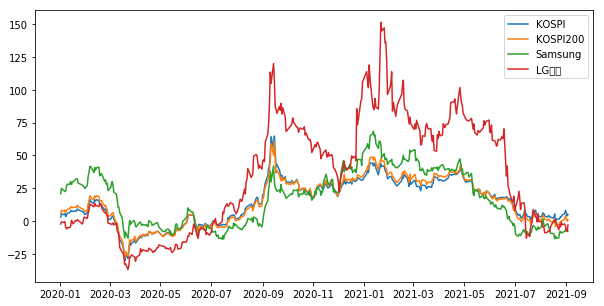

In [650]:
fig = plt.figure(figsize=(10,5))
fig.tight_layout()
subplot = fig.add_subplot(1,1,1)

for k, v in std_list.items():
    name = v['name']
    ticker_data = v['data']
    subplot.plot(ticker_data['prev_rate180'], label=name)
    subplot.legend()
    
for k, v in ticker_list.items():
    name = v['name']
    ticker_data = v['data']
    subplot.plot(ticker_data['prev_rate180'], label=name)
    subplot.legend()
plt.show()

## 100기준 수익률 차트

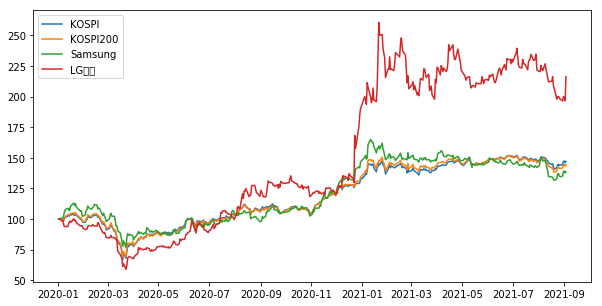

In [651]:
fig = plt.figure(figsize=(10,5))
fig.tight_layout()
subplot = fig.add_subplot(1,1,1)

for k, v in std_list.items():
    name = v['name']
    ticker_data = v['data']
    subplot.plot(ticker_data['relative_value'], label=name)
    subplot.legend()
    
for k, v in ticker_list.items():
    name = v['name']
    ticker_data = v['data']
    subplot.plot(ticker_data['relative_value'], label=name)
    subplot.legend()
plt.show()

## 개별 종목 가격, 이동평균 차트

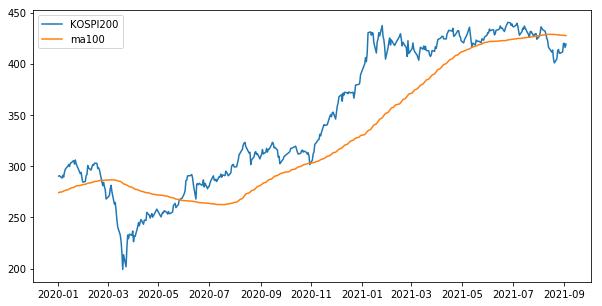

In [653]:
fig = plt.figure(figsize=(10,5))
fig.tight_layout()
subplot = fig.add_subplot(1,1,1)
    
code = "KS200"
ticker_data = std_list[code]['data']
subplot.plot(ticker_data['Close'], label=std_list[code]['name'])
#subplot.plot(ticker_data['ma5'], label='ma5')
#subplot.plot(ticker_data['ma25'], label='ma25')
#subplot.plot(ticker_data['ma50'], label='ma50')
subplot.plot(ticker_data['ma100'], label='ma100')
subplot.legend()
plt.show()

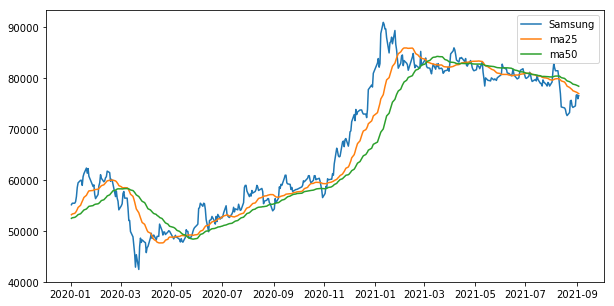

In [654]:
fig = plt.figure(figsize=(10,5))
fig.tight_layout()
subplot = fig.add_subplot(1,1,1)
    
code = "005930.KS"
ticker_data = ticker_list[code]['data']
subplot.plot(ticker_data['Close'], label=ticker_list[code]['name'])
#subplot.plot(ticker_data['ma5'], label='ma5')
subplot.plot(ticker_data['ma25'], label='ma25')
subplot.plot(ticker_data['ma50'], label='ma50')
#subplot.plot(ticker_data['ma100'], label='ma100')
subplot.legend()
plt.show()

## 자산 관리 - 종목 매수, 매도

In [555]:
class Stock:
    def __init__(self, code):
        self.code = code
        self.count = 0
        self.price = 0
        self.ammount = 0
        
    def buy(self, count, price):
        self.count += count
        self.price = price
        self.apply(price)
        
    def sell(self, count, price):
        self.count -= count
        self.price = price
        self.apply(price)
        
    def apply(self, price):
        self.price = price
        self.amount = self.count * self.price
        
class Asset:
    def __init__(self, cash):
        self.stocks = { }
        self.cash = cash
        self.total = cash
    
    def get_stock_count(self):
        return len(self.stocks)
    
    def buy(self, code, count, price):
        print("buy:", code, count, price)
        stock = self.get_stock(code)
        
        amount = count * price
        self.cash -= amount # TODO cash 부족시
        stock.buy(count, price)
        self.eval()
        
    def get_buy_count(self, price):
        count = math.floor(self.cash / price)
        return count
    
    def sell(self, code, price):
        if (not self.is_stock(code)):
            print("Asset.sell(): stock not exist", code)
            return

        stock = self.get_stock(code)
        count = stock.count
        amount = count * price
        stock.sell(count, price)
        self.cash += amount
        
        print("sell:", code, count, price)
        if (stock.count == 0):
            del self.stocks[code]
        self.eval()
    
    def apply(self, code, price):
        if (self.is_stock(code)):
            stock = self.get_stock(code)
            stock.apply(price)
            self.eval()
        
    def get_stock(self, code):
        if code in self.stocks:
            return self.stocks[code]
        else:
            stock = Stock(code)
            self.stocks[code] = stock;
            return stock
        
    def is_stock(self, code):
        if code in self.stocks:
            return True
        return False
        
    def eval(self):
        stock_total = 0
        for k, v in self.stocks.items():
            stock_total += v.amount
        self.total = stock_total + self.cash
        return self.total
    
    def display(self):
        print("asset:", "total=", self.total, "cash=", self.cash)
        #for k, v in self.stocks.items():
        #    print(v.code, v.count, v.price, v.amount)


In [533]:
code = "005930.KS"
asset = Asset(10000000)
asset.buy(code, 10, 70000)
asset.apply(code, 80000)
asset.sell(code, 90000)
asset.display()

buy: 005930.KS 10 70000
sell: 005930.KS 10 90000
asset: total= 10200000 cash= 10200000


## 종목 이벤트 이력

In [608]:
UNKNOWN_TREND = 0
DOWN_TREND = -1
UP_TREND = 1
class StockHistory:
    def __init__(self, code):
        self.code = code
        self.trend = UNKNOWN_TREND
        self.event_histories = [ ]

class StockHistoryStore:
    def __init__(self):
        self.stock_histories = { }
        
    def get_stock_history(self, code):
        if code in self.stock_histories:
            return self.stock_histories[code]
        else:
            stock_history = StockHistory(code)
            self.stock_histories[code] = stock_history;
            return stock_history

# 시스템

In [520]:
batch_data = pd.DataFrame()
idx = '2020-01-02'
for k, v in ticker_list.items():
    copy = v['data'].loc[idx].copy() # ticker_data
    copy['code'] = k
    batch_data = batch_data.append(copy)
batch_filtered_data = batch_data[batch_data.ma25 > batch_data.ma50]
batch_filtered_data.sort_values(by='prev_rate180', ascending=False)

,Adj Close,Close,High,Low,Open,Volume,code,ma100,ma25,ma5,ma50,prev_close180,prev_rate180,relative_value
2020-01-02,52305.605469,55200.0,56000.0,55000.0,55500.0,12993228.0,005930.KS,49458.5,53238.0,55580.0,52535.0,45650.0,20.920044,100.0
2020-01-02,70315.664062,71000.0,72100.0,71000.0,71800.0,284758.0,066570.KS,67069.0,71288.0,71620.0,70266.0,72600.0,-2.203857,100.0


In [585]:
code = "005930.KS"
idx = '2020-01-02'
ticker_data = ticker_list[code]['data']
ticker_data.loc[idx]

High              5.600000e+04
Low               5.500000e+04
Open              5.550000e+04
Close             5.520000e+04
Volume            1.299323e+07
Adj Close         5.230561e+04
prev_close180     4.565000e+04
prev_rate180      2.092004e+01
relative_value    1.000000e+02
ma5               5.558000e+04
ma25              5.323800e+04
ma50              5.253500e+04
ma100             4.945850e+04
Name: 2020-01-02 00:00:00, dtype: float64

In [615]:
class LTHM: # LongTrendHighMomentum
    def __init__(self, max_position=10, max_percent=10, cash=10000000):
        self.MAX_POSITION = max_position # 최대 종목 갯수
        self.MAX_PERCENT = max_percent # 전체 자산 대비 종목별 최대 비중
        self.RISK_PERCENT = 2 # 손실 위험
        self.stock_history_store = StockHistoryStore()
        self.asset = Asset(cash)
        self.data = pd.DataFrame(columns=['total', 'cash'])
        self.action_histories = [ ]
    
    def filter(self, idx):
        batch_data = pd.DataFrame()
        for k, v in ticker_list.items():
            if (idx in v['data'].index):
                copy = v['data'].loc[idx].copy()
                copy['code'] = k
                batch_data = batch_data.append(copy)
        if (len(batch_data) == 0):
            return batch_data
        #filtered_data = batch_data[batch_data.ma25 > batch_data.ma50]
        return batch_data[batch_data.ma25 > batch_data.ma50].sort_values(by='prev_rate180', ascending=False)
    
    def prioritize(self, idx):
        return self.filter(idx)
    
    def backtest(self):
        ticker_data = std_list['^KS11']['data'] # idx 가져오기 위해 지수 종목 사용
        for idx, row in ticker_data.iterrows():
            self.apply(idx)
        
        add_relative_value(self.data, 'total') # total 값을 이용하여 relative_value 컬럼 추가
        return
    
    def apply(self, idx):
        # 신규 종목 체크
        filtered_data = self.prioritize(idx)
        #print("filtered_data=", filtered_data)
        for idx, row in filtered_data.iterrows():
            code = row['code']
            self.apply_stock(code, idx, row)
            
        # 보유 종목 체크
        for k in list(self.asset.stocks.keys()):
            code = k
            ticker_data = ticker_list[code]['data']
            row = ticker_data.loc[idx]
            self.apply_stock(code, idx, row)

        self.data = self.data.append(pd.Series({'total':self.asset.total, 'cash':self.asset.cash}, index=self.data.columns, name=idx))
        
    def apply_stock(self, code, idx, row):
        stock_history = self.stock_history_store.get_stock_history(code)
        self.asset.apply(code, row['Close'])
        
        if (self.on_uptrend(stock_history, idx, row) and not self.asset.is_stock(code)):
            count = self.get_buy_count(row['Close'])
            if (count > 0):
                self.asset.buy(code, count, row['Close'])
                self.asset.display()
                action = { "name": "buy", "idx": idx, "code": code, "count": count, "price": row['Close']}
                self.action_histories.append(action)
        if (self.on_downtrend(stock_history, idx, row) and self.asset.is_stock(code)):
            stock = self.asset.get_stock(code)
            count = stock.count
            if (count > 0):
                self.asset.sell(code, row['Close'])
                self.asset.display()
                action = { "name": "sell", "idx": idx, "code": code, "count": count, "price": row['Close']}
                self.action_histories.append(action)
            
    def get_buy_count(self, price):
        stock_count = self.asset.get_stock_count()
        remain_position_count = self.MAX_POSITION - stock_count
        if (remain_position_count < 1):
            return 0
        position_cash = self.asset.cash / remain_position_count
        position_limit = self.asset.total * self.MAX_PERCENT / 100
        print("cash=", self.asset.cash, "remain_position_count=", remain_position_count, "position_cash=", position_cash, "position_limit=", position_limit)
        if (position_cash > position_limit):
            position_cash = position_limit
        return math.floor(position_cash / price)
            
    def on_uptrend(self, stock_history, idx, row):
        if (stock_history.trend != UP_TREND and row['ma25'] > row['ma50']):
            stock_history.trend = UP_TREND
            event = { "idx": idx, "code": stock_history.code, "name": "uptrend"}
            stock_history.event_histories.append(event)
            print("event:", event)
            return True
        return False
    
    def on_downtrend(self, stock_history, idx, row):
        if (stock_history.trend != DOWN_TREND and row['ma25'] < row['ma50']):
            stock_history.trend = DOWN_TREND
            event = { "idx": idx, "code": stock_history.code, "name": "downtrend"}
            stock_history.event_histories.append(event)
            print("event:", event)
            return True
        return False


In [616]:
ticker_list = ticker_list_one.copy()
system = LTHM(max_position=1, max_percent=100)
system.backtest()
#system.action_histories

event: {'idx': Timestamp('2020-01-02 00:00:00'), 'code': '005930.KS', 'name': 'uptrend'}
cash= 10000000 remain_position_count= 1 position_cash= 10000000.0 position_limit= 10000000.0
buy: 005930.KS 181 55200.0
asset: total= 10000000.0 cash= 8800.0
event: {'idx': Timestamp('2020-03-10 00:00:00'), 'code': '005930.KS', 'name': 'downtrend'}
sell: 005930.KS 181 54600.0
asset: total= 9891400.0 cash= 9891400.0
event: {'idx': Timestamp('2020-05-19 00:00:00'), 'code': '005930.KS', 'name': 'uptrend'}
cash= 9891400.0 remain_position_count= 1 position_cash= 9891400.0 position_limit= 9891400.0
buy: 005930.KS 196 50300.0
asset: total= 9891400.0 cash= 32600.0
event: {'idx': Timestamp('2021-03-05 00:00:00'), 'code': '005930.KS', 'name': 'downtrend'}
sell: 005930.KS 196 82100.0
asset: total= 16124200.0 cash= 16124200.0
event: {'idx': Timestamp('2021-04-14 00:00:00'), 'code': '005930.KS', 'name': 'uptrend'}
cash= 16124200.0 remain_position_count= 1 position_cash= 16124200.0 position_limit= 16124200.0
buy

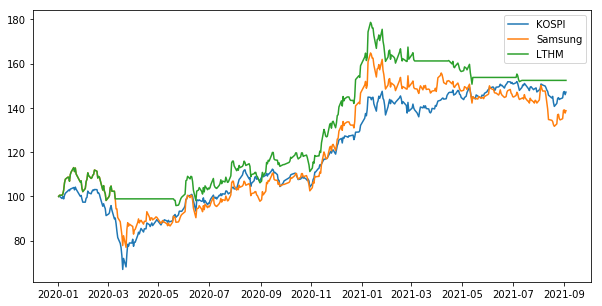

In [621]:
show_chart()

In [622]:
ticker_list = ticker_list_two.copy()
system = LTHM(max_position=2, max_percent=50)
system.backtest()
#system.apply('2020-01-02')
#system.apply('2020-01-03')
#system.action_histories

event: {'idx': Timestamp('2020-01-02 00:00:00'), 'code': '005930.KS', 'name': 'uptrend'}
cash= 10000000 remain_position_count= 2 position_cash= 5000000.0 position_limit= 5000000.0
buy: 005930.KS 90 55200.0
asset: total= 10000000.0 cash= 5032000.0
event: {'idx': Timestamp('2020-01-02 00:00:00'), 'code': '066570.KS', 'name': 'uptrend'}
cash= 5032000.0 remain_position_count= 1 position_cash= 5032000.0 position_limit= 5000000.0
buy: 066570.KS 70 71000.0
asset: total= 10000000.0 cash= 62000.0
event: {'idx': Timestamp('2020-01-22 00:00:00'), 'code': '066570.KS', 'name': 'downtrend'}
sell: 066570.KS 70 70400.0
asset: total= 10597000.0 cash= 4990000.0
event: {'idx': Timestamp('2020-03-10 00:00:00'), 'code': '005930.KS', 'name': 'downtrend'}
sell: 005930.KS 90 54600.0
asset: total= 9904000.0 cash= 9904000.0
event: {'idx': Timestamp('2020-05-12 00:00:00'), 'code': '066570.KS', 'name': 'uptrend'}
cash= 9904000.0 remain_position_count= 2 position_cash= 4952000.0 position_limit= 4952000.0
buy: 0665

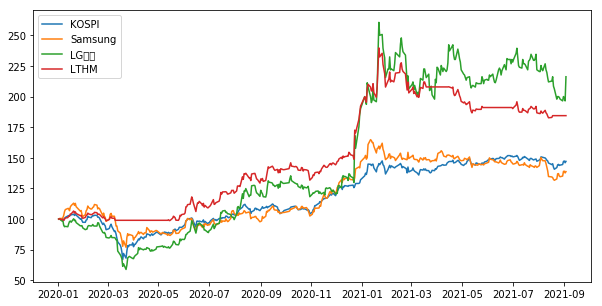

In [623]:
show_chart()